In [ ]:
pip install "tensorflow>=1.15.2,<2.0"

     |████████████████████████████████| 110.5MB 97kB/s 
     |████████████████████████████████| 512kB 51.0MB/s 
     |████████████████████████████████| 20.1MB 81.8MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 3.8MB 45.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=0cf212bb16d64ddb988af3e80afb25db1a58cd195d252e49d4b8d2e3ea38335c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.

In [ ]:
pip install "tensorflow-gpu>=1.15.2,<2.0"

     |████████████████████████████████| 411.0MB 41kB/s 


In [ ]:
pip install ampligraph

     |████████████████████████████████| 153kB 18.0MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 2.8MB 30.6MB/s 
     |████████████████████████████████| 235kB 47.6MB/s 
     |████████████████████████████████| 2.7MB 57.0MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 563kB 51.9MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 122kB 62.7MB/s 
     |████████████████████████████████| 92kB 11.7MB/s 
     |████████████████████████████████| 92kB 13.0MB/s 
     |████████████████████████████████| 102kB 12.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Sphinx 1.8.5
    Uninstalling Sphinx-1.8.5:
      Successfully uninstalled Sphinx-1.8.5


In [ ]:
pip install rdflib

In [ ]:
pip install seaborn adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp37-none-any.whl size=7100 sha256=37d163cd37f73b41e92be18034bd2814974739c51f42f97a26e7861f88e05d69
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ampligraph
import rdflib
import tensorflow as tf
import seaborn as sns
import pickle
from ampligraph.evaluation import train_test_split_no_unseen 
from ampligraph.latent_features import ComplEx
from sklearn.decomposition import PCA
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans
from adjustText import adjust_text
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# **Import KG**

In [ ]:
g = rdflib.Graph()
g.parse('/content/gdrive/My Drive/statements.nq', format='nquads')
print(len(g))

367941


# **Convert KG to PD**

In [ ]:
rows = []
for s, p, o in g:
    rows.append([s, p, o])

In [ ]:
triples = pd.DataFrame(rows, columns=['subject', 'predicate', 'object'])

# **Train KG Embeddings**

In [ ]:
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)
X_train = X_train.astype('<U48')
X_valid = X_valid.astype('<U48')
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (357941, 3)
Test set size:  (10000, 3)


In [ ]:
model = ComplEx(batches_count=50,
                epochs=300,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=0, 
                verbose=True)
tf.logging.set_verbosity(tf.logging.ERROR)
model.fit(X_train)

Average Loss:   0.653415: 100%|██████████| 300/300 [14:41<00:00,  2.94s/epoch]


# **Find Similarities**

In [ ]:
def Filter(string, substring):
    return [str for str in string if
             any(sub in str for sub in substring)]
string = X_train[:, 0]
substring = ['https://foodb.ca/foods/0', 'https://foodb.ca/foods/1', 'https://foodb.ca/foods/2', 'https://foodb.ca/foods/3', 
          'https://foodb.ca/foods/4', 'https://foodb.ca/foods/5', 'https://foodb.ca/foods/6', 'https://foodb.ca/foods/7', 
          'https://foodb.ca/foods/8', 'https://foodb.ca/foods/9' ]
foods = (Filter(string, substring))
foods = np.unique(foods)
len(foods)

901

In [ ]:
food_embeddings = dict(zip(foods, model.get_embeddings(foods)))

In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in food_embeddings.values()]))

# **Method 1: K-Means Clustering**

In [ ]:
clustering_algorithm = KMeans(n_clusters=23, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(foods, model, clustering_algorithm, mode='entity')

In [ ]:
plot_df = pd.DataFrame({"foods": foods, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})
plot_df['foods'] = plot_df['foods'].map(lambda x: x.lstrip('https://foodb.ca/foods/'))

food = pd.read_csv('/content/gdrive/My Drive/Food.csv')
food = food.replace('NA',np.nan)
food = food[['id', 'name', 'food_group', 'food_subgroup']]
food = food.dropna()

for i in range(len(food)):
  food_id = food['id'].iloc[i]
  food_name = food[food['id'] == food_id]['name'].iloc[0]
  food_group = food[food['id'] == food_id]['food_group'].iloc[0]
  food_subgroup = food[food['id'] == food_id]['food_subgroup'].iloc[0]
  index = plot_df[plot_df['foods'] == str(food_id)].index
  plot_df.at[index, 'food_name'] = food_name
  plot_df.at[index, 'food_group'] = food_group
  plot_df.at[index, 'food_subgroup'] = food_subgroup

plot_df = plot_df.dropna()

In [ ]:
pickle.dump(plot_df, open('plot_df.pkl', 'wb'))
files.download('plot_df.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_df = pd.read_pickle('/content/gdrive/My Drive/plot_df.pkl')

500

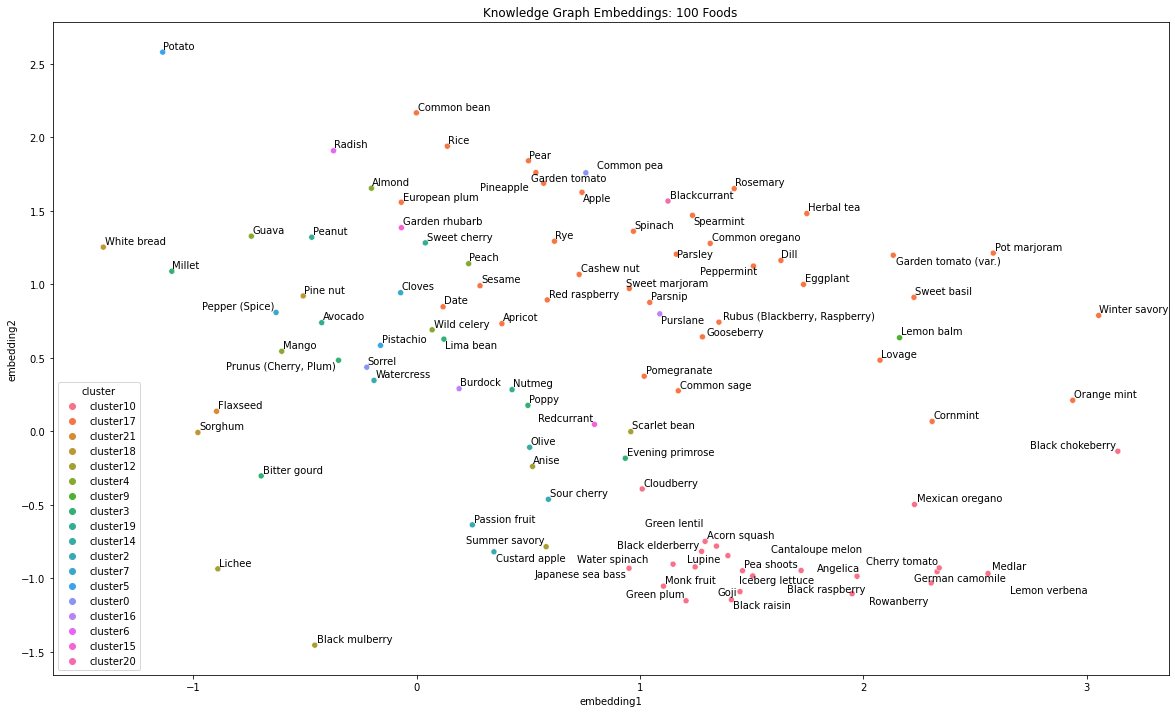

In [ ]:
plot_df_100 = plot_df[:100]
plt.figure(figsize=(20,12))
plt.title('Knowledge Graph Embeddings: 100 Foods')
ax = sns.scatterplot(data=plot_df_100, x="embedding1", y="embedding2", hue='cluster')
texts = []
for i, point in plot_df_100.iterrows():
  texts.append(plt.text(point['embedding1'], point['embedding2'], str(point['food_name'])))
adjust_text(texts)

70

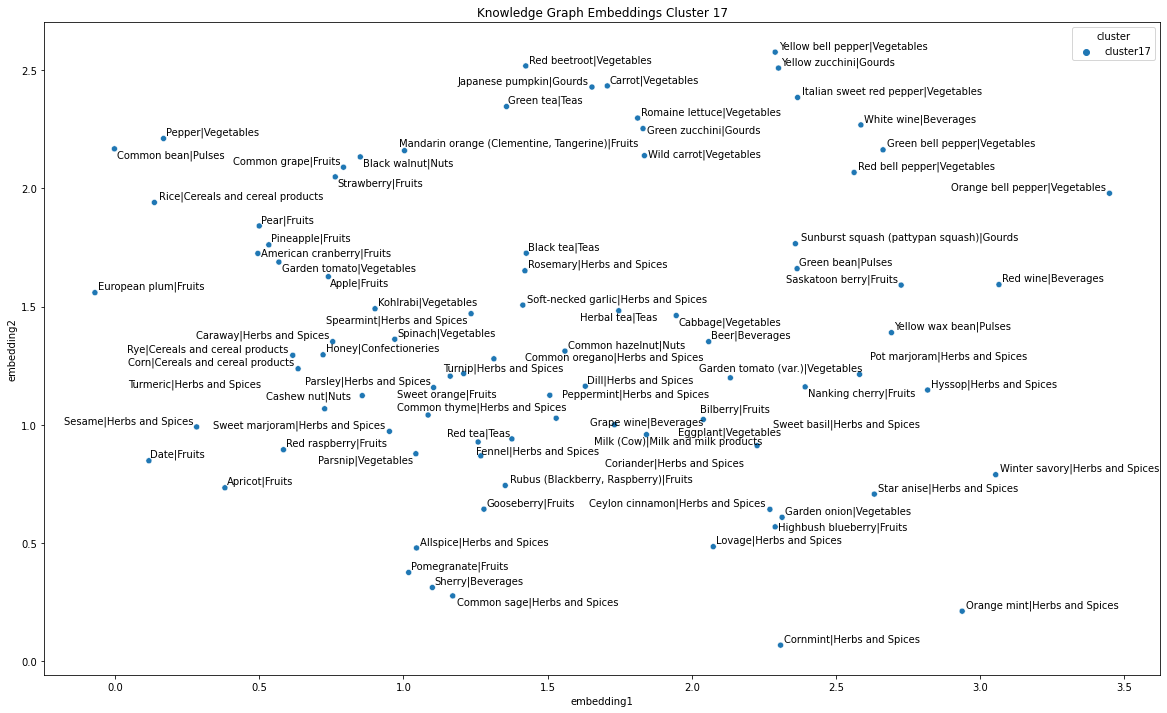

In [ ]:
cluster = plot_df[plot_df['cluster'] == 'cluster17']
plt.figure(figsize=(20,12))
plt.title('Knowledge Graph Embeddings Cluster 17')
ax = sns.scatterplot(data=cluster, x="embedding1", y="embedding2", hue='cluster')
texts = []
for i, point in cluster.iterrows():
  texts.append(plt.text(point['embedding1'], point['embedding2'], str(point['food_name'])+'|'+str(point['food_group'])))
adjust_text(texts)

6

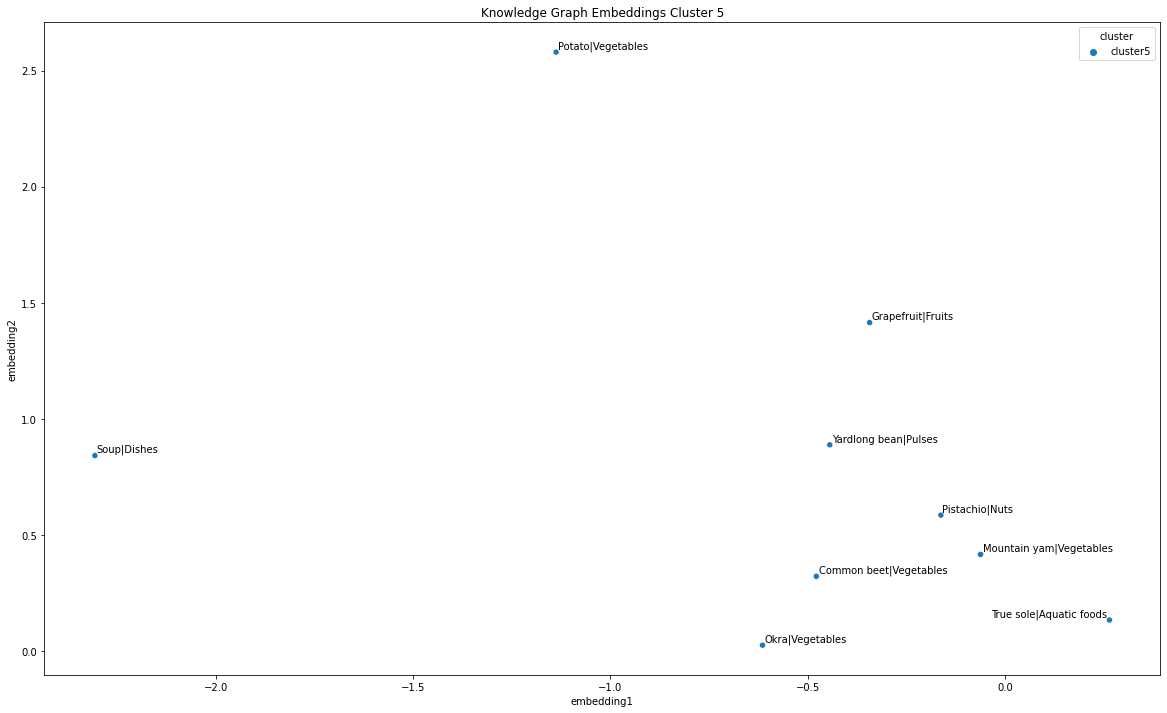

In [ ]:
cluster = plot_df[plot_df['cluster'] == 'cluster5']
plt.figure(figsize=(20,12))
plt.title('Knowledge Graph Embeddings Cluster 5')
ax = sns.scatterplot(data=cluster, x="embedding1", y="embedding2", hue='cluster')
texts = []
for i, point in cluster.iterrows():
  texts.append(plt.text(point['embedding1'], point['embedding2'], str(point['food_name'])+'|'+str(point['food_group'])))
adjust_text(texts)

# **Method 2: Cosine Similarity**

In [ ]:
embeddings = np.array([plot_df['embedding1'], plot_df['embedding2']]).transpose()
cosine_similarity = cosine_similarity(embeddings)
df = pd.DataFrame(data=cosine_similarity, columns=plot_df['food_name'])
df.index = plot_df['food_name']

In [ ]:
temp = df['Common oregano']
sorted_temp = temp.sort_values(axis=0, ascending=False)
sorted_temp[:11]

food_name
Common oregano              1.000000
Common thyme                0.999973
Lime                        0.999919
Turnip                      0.999864
Italian sweet red pepper    0.999855
Sweet marjoram              0.999709
Cocoa bean                  0.999546
Parsley                     0.999497
Sweet orange                0.999326
Ymer                        0.999239
Soft-necked garlic          0.998991
Name: Common oregano, dtype: float32